https://www.kaggle.com/anttip/wordbatch-ftrl-fm-lgb-lbl-0-42555
https://towardsdatascience.com/machine-learning-for-retail-price-suggestion-with-python-64531e64186d

In [ ]:
!pip install tensorflow==2.0.0
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
import keras
print(tf.__version__)
print(keras.__version__)

2.0.0
2.3.1


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [ ]:
import io
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
SEED = 7
np.random.seed(SEED)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from tensorflow.python import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.utils import shuffle
# Visualizing the intermediate layer
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# !pip install wordbatch
# import wordbatch
# from wordbatch.extractors import WordBag, WordHash
# from wordbatch.models import FTRL, FM_FTRL

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, GRU, Embedding
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# from tensorflow.keras.backend import square, mean

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['Train.csv']), parse_dates=["Date"],infer_datetime_format=True, dayfirst=True)

In [ ]:
uploaded1 = files.upload()

Saving Test.csv to Test.csv


In [ ]:
df_test = pd.read_csv(io.BytesIO(uploaded1['Test.csv']), parse_dates=["Date"],infer_datetime_format=True, dayfirst=True)

In [ ]:
NUM_CATEGORIES = 35

In [ ]:
#develop = False
develop= True

In [ ]:
import math

In [ ]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.math.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))

In [ ]:
df = df.rename(columns={"Selling_Price": "price"})
df_test = df_test.rename(columns={"Selling_Price": "price"})
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.info())
print(df.describe())
print(df.describe(exclude=[np.number]))

(2452, 8)
Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'price'],
      dtype='object')
Product                  object
Product_Brand            object
Item_Category            object
Subcategory_1            object
Subcategory_2            object
Item_Rating             float64
Date             datetime64[ns]
price                   float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Product        2452 non-null   object        
 1   Product_Brand  2452 non-null   object        
 2   Item_Category  2452 non-null   object        
 3   Subcategory_1  2452 non-null   object        
 4   Subcategory_2  2452 non-null   object        
 5   Item_Rating    2452 non-null   float64       
 6   Date           2452 non-null   datetime64[ns]
 7   pr

In [ ]:
#For classification data
df.describe(include=['O'])
cat_df = df.select_dtypes(include = ['object'])
cat_df.describe()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2
count,2452,2452,2452,2452,2452
unique,2452,1010,75,130,336
top,P-11126,B-3078,clothing,women s clothing,western wear
freq,1,688,717,476,267


In [ ]:
def to_categorical(dataset):
    dataset['Product_Brand'] = dataset['Product_Brand'].astype('category')
    dataset['Item_Category'] = dataset['Item_Category'].astype('category')
    dataset['Subcategory_1'] = dataset['Subcategory_1'].astype('category')
    dataset['Subcategory_2'] = dataset['Subcategory_2'].astype('category')

# def to_year(dfl):
#   dfl['Date']=dfl.Date.dt.year

def to_scale(dfl):
  dfl['Item_Rating'] = np.log1p(dfl["Item_Rating"])

def cutting(dataset):
    pop_category1 = dataset['Item_Category'].value_counts().loc[lambda x: x.index != 'unknown'].index[:NUM_CATEGORIES]
    pop_category2 = dataset['Subcategory_1'].value_counts().loc[lambda x: x.index != 'unknown'].index[:NUM_CATEGORIES]
    pop_category3 = dataset['Subcategory_2'].value_counts().loc[lambda x: x.index != 'unknown'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['Item_Category'].isin(pop_category1), 'Item_Category'] = 'unknown'
    dataset.loc[~dataset['Subcategory_1'].isin(pop_category2), 'Subcategory_1'] = 'unknown'
    dataset.loc[~dataset['Subcategory_2'].isin(pop_category3), 'Subcategory_2'] = 'unknown'

def check_qmark(d):
  a = d.count()
  tot = a[0]
  print(d.isin(['unknown']).sum(axis=0)*100/tot)
check_qmark(df)

Product          0.000000
Product_Brand    0.000000
Item_Category    0.000000
Subcategory_1    1.876020
Subcategory_2    9.298532
Item_Rating      0.000000
Date             0.000000
price            0.000000
dtype: float64


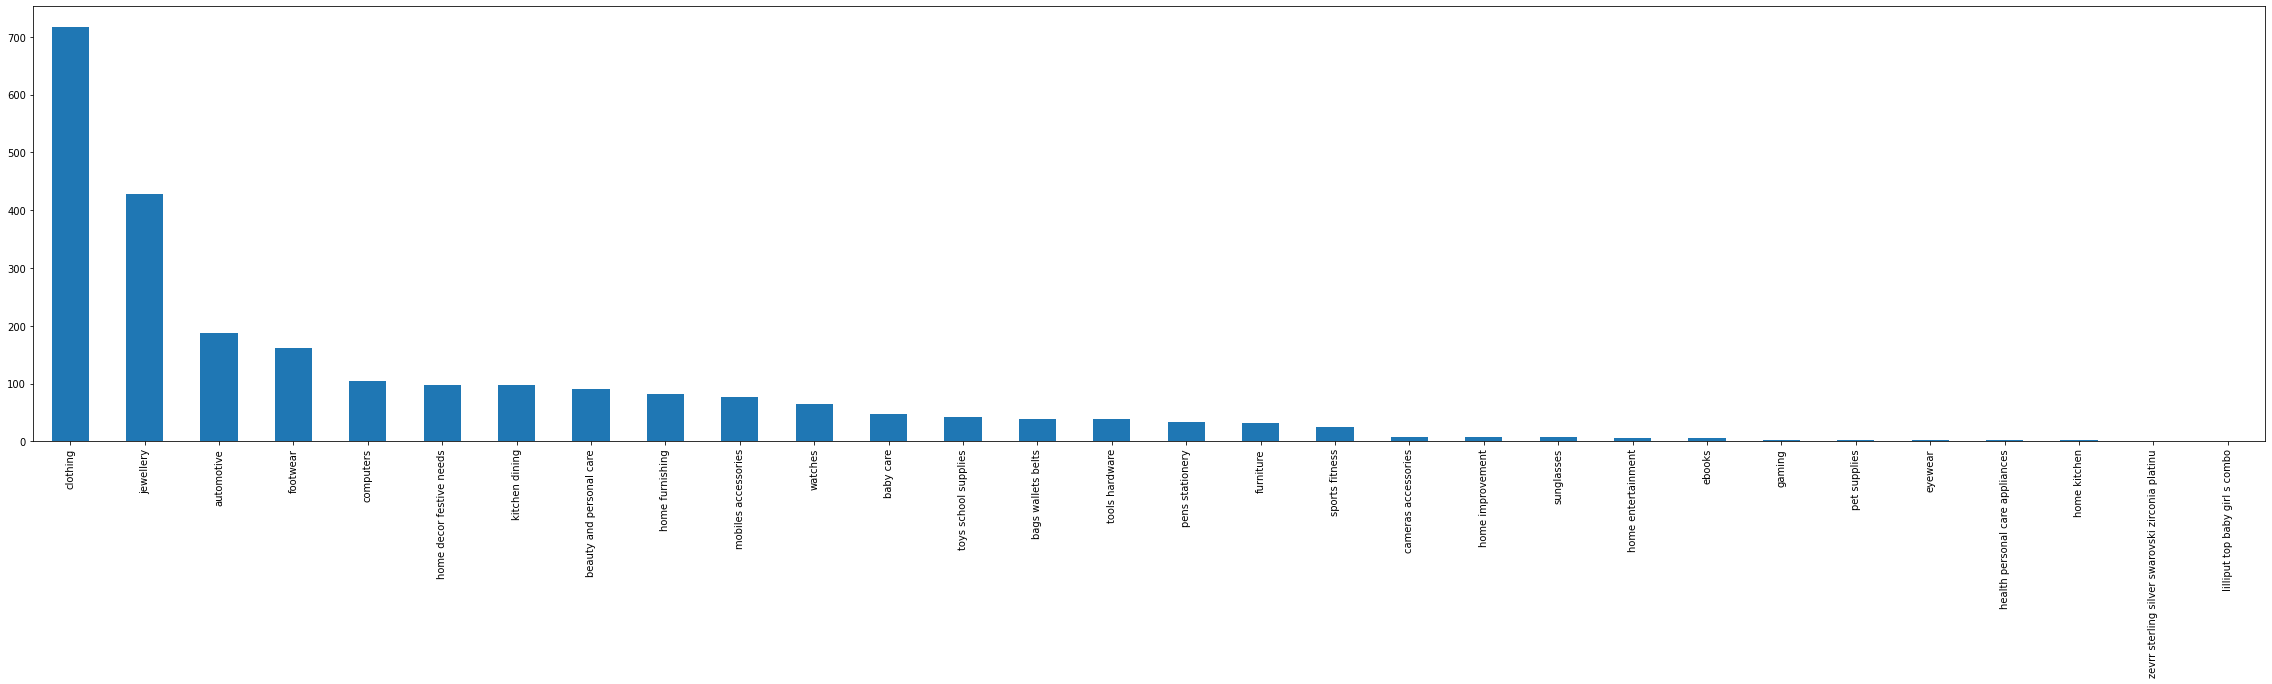

In [ ]:
plt.figure(figsize=(40, 8))
cc = df['Item_Category'].value_counts()[:30]
ax = cc.plot.bar()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),
 <a list of 75 Text major ticklabel objects>)

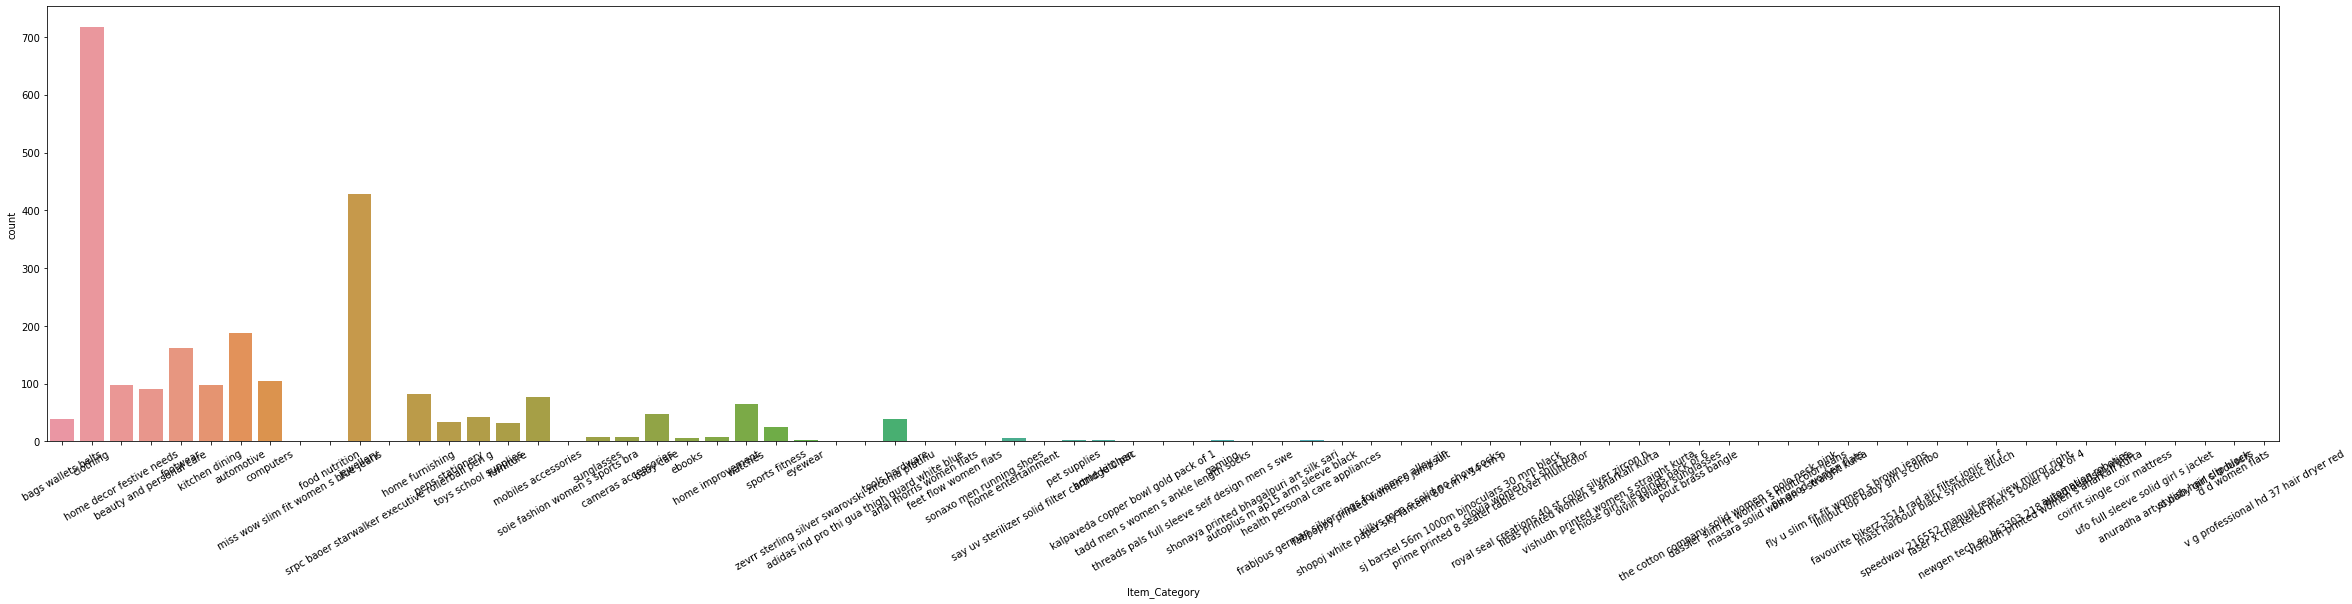

In [ ]:
plt.figure(figsize=(40, 8))
sns.countplot('Item_Category',data=df)
plt.xticks(rotation=30)

In [ ]:
start_time = time.time()
from time import gmtime, strftime
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

2020-06-15 10:15:26


In [ ]:
df.drop('Date', axis=1, inplace=True)
df_test.drop('Date', axis=1, inplace=True)

In [ ]:
df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'price'],
      dtype='object')

In [ ]:
train = df.copy()
test = df_test.copy()

In [ ]:
print('[{}] Finished to load data'.format(time.time() - start_time))
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

[0.06993627548217773] Finished to load data
Train shape:  (2452, 7)
Test shape:  (1051, 6)


In [ ]:
nrow_test = train.shape[0]  # -dftt.shape[0]
dftt = train[(train.price < 1.0)]
train = train.drop(train[(train.price < 1.0)].index)
del dftt['price']
nrow_train = train.shape[0]
print('nrow_test:', nrow_test)
print('nrow_train', nrow_train)
y = np.log1p(train["price"])
merge = pd.DataFrame = pd.concat([train, dftt, test])
submission = pd.DataFrame = test[['Product']]

nrow_test: 2452
nrow_train 2452


In [ ]:
merge.shape

(3503, 7)

In [ ]:
submission.shape

(1051, 1)

In [ ]:
del train
del test
gc.collect()

17158

In [ ]:
merge.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'price'],
      dtype='object')

In [ ]:
#cutting(merge)
to_categorical(merge)
#to_year(merge)
to_scale(merge)
print('[{}] Preprocessing completed'.format(time.time() - start_time))
print(merge.dtypes)

[0.4241526126861572] Preprocessing completed
Product            object
Product_Brand    category
Item_Category    category
Subcategory_1    category
Subcategory_2    category
Item_Rating       float64
price             float64
dtype: object


In [ ]:
lb = LabelBinarizer(sparse_output=True)
X_Product_Brand = lb.fit_transform(merge['Product_Brand'])

In [ ]:
wb = CountVectorizer()
X_Item_Category = wb.fit_transform(merge['Item_Category'])
X_Subcategory_1 = wb.fit_transform(merge['Subcategory_1'])
X_Subcategory_2 = wb.fit_transform(merge['Subcategory_2'])
print('[{}] Count vectorize `categories` completed.'.format(time.time() - start_time))

[0.6302146911621094] Count vectorize `categories` completed.


In [ ]:
X_Item_Category

<3503x291 sparse matrix of type '<class 'numpy.int64'>'
	with 5402 stored elements in Compressed Sparse Row format>

In [ ]:
X_Item_Category

<3503x291 sparse matrix of type '<class 'numpy.int64'>'
	with 5402 stored elements in Compressed Sparse Row format>

In [ ]:
# X_others = merge[['Item_Rating', 'Date']]
X_others = merge[['Item_Rating']]

In [ ]:
ad = merge.Item_Rating.values
ad.dtype

dtype('float64')

In [ ]:
X_others.values

array([[1.66770682],
       [1.41098697],
       [1.5040774 ],
       ...,
       [1.5040774 ],
       [1.22377543],
       [1.41098697]])

In [ ]:
 print(X_Product_Brand.shape, X_Item_Category.shape, X_Subcategory_1.shape, X_Subcategory_2.shape, X_others.shape)

(3503, 1313) (3503, 291) (3503, 202) (3503, 585) (3503, 1)


In [ ]:
merge.dtypes

Product            object
Product_Brand    category
Item_Category    category
Subcategory_1    category
Subcategory_2    category
Item_Rating       float64
price             float64
dtype: object

In [ ]:
sparse_merge = hstack((X_Product_Brand, X_Item_Category, X_Subcategory_1, X_Subcategory_2, X_others)).tocsr()

In [ ]:
sparse_merge.shape

(3503, 2392)

In [ ]:
print('[{}] Create sparse merge completed'.format(time.time() - start_time))

[0.748075008392334] Create sparse merge completed


In [ ]:
 # Remove features with document frequency <=1
print(sparse_merge.shape)
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]
sparse_merge.shape
print(sparse_merge.shape)

(3503, 2392)
(3503, 882)


In [ ]:
#Separate train and test data from sparse merge
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_test:]

In [ ]:
gc.collect()
train_X, train_y = X, y

In [ ]:
df.head(20)

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,470.0
5,P-5597,B-1487,home decor festive needs,table decor handicrafts,showpieces,5.0,746.0
6,P-8398,B-3078,footwear,women s footwear,casual shoes,4.1,1798.0
7,P-10744,B-2830,kitchen dining,cookware,pots pans,3.1,955.0
8,P-4042,B-1045,home decor festive needs,wall decor clocks,paintings,2.4,21770.0
9,P-360,B-88,automotive,accessories spare parts,car interior exterior,2.3,199.0


In [ ]:
if develop:
  train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.05, random_state=100)
  print(valid_X.shape)

(123, 882)


In [ ]:
from sklearn.linear_model import Ridge
import math
from sklearn import metrics

In [ ]:
model = Ridge(solver="sag", random_state=42, alpha=0.5)
model.fit(train_X, train_y)
print('[{}] Train Ridge completed'.format(time.time() - start_time))
if develop:
    preds = model.predict(X=valid_X)
    print("Ridge dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
predsF = model.predict(X_test)
print('[{}] Predict Ridge completed'.format(time.time() - start_time))

[1.0114102363586426] Train Ridge completed
Ridge dev RMSLE: 0.5973931293047419
[1.0138709545135498] Predict Ridge completed


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
params = {
    'learning_rate': 0.1,
    'application': 'regression',
    'max_depth': 12,
    'verbosity': -1,
    'n_estimators': 119,
    'num_leaves': 27,
    'metric': 'RMSE',
    'data_random_seed': 1
}

d_train = lgb.Dataset(train_X, label=train_y)
watchlist = [d_train]
if develop:
    d_valid = lgb.Dataset(valid_X, label=valid_y)
    watchlist = [d_train, d_valid]

model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist)

if develop:
    preds = model.predict(valid_X)
    print("LGB dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))

predsL = model.predict(X_test)

[1]	training's rmse: 1.10792	valid_1's rmse: 1.11787
[2]	training's rmse: 1.04908	valid_1's rmse: 1.06207
[3]	training's rmse: 0.998773	valid_1's rmse: 1.01519
[4]	training's rmse: 0.955677	valid_1's rmse: 0.97539
[5]	training's rmse: 0.919403	valid_1's rmse: 0.94152
[6]	training's rmse: 0.888367	valid_1's rmse: 0.914913
[7]	training's rmse: 0.861914	valid_1's rmse: 0.892879
[8]	training's rmse: 0.839922	valid_1's rmse: 0.876168
[9]	training's rmse: 0.821599	valid_1's rmse: 0.862866
[10]	training's rmse: 0.80628	valid_1's rmse: 0.852275
[11]	training's rmse: 0.793504	valid_1's rmse: 0.845167
[12]	training's rmse: 0.782408	valid_1's rmse: 0.836944
[13]	training's rmse: 0.772675	valid_1's rmse: 0.831786
[14]	training's rmse: 0.764514	valid_1's rmse: 0.827216
[15]	training's rmse: 0.75771	valid_1's rmse: 0.82308
[16]	training's rmse: 0.75095	valid_1's rmse: 0.820182
[17]	training's rmse: 0.745766	valid_1's rmse: 0.818577
[18]	training's rmse: 0.7414	valid_1's rmse: 0.816746
[19]	training'

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGB dev RMSLE: 0.7265843779309232


In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [ ]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(20, 500),
          'num_leaves': sp_randint(20, 50),
          'max_depth': sp_randint(2, 30),
          'min_child_weight': uniform(0, 1),
          'colsample_bytree': uniform(0, 1),
         }
        
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', return_train_score=True)
lgb_random = lgb_random.fit(train_X, train_y)

best_params = lgb_random.best_params_
print(best_params)
model1 = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model1.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model1.predict(X=valid_X)
    print("LGBM dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
predsF = model1.predict(X_test)
#print('[{}] Predict LGBM completed'.format(time.time() - start_time))

{'colsample_bytree': 0.44583275285359114, 'learning_rate': 0.09997491581800289, 'max_depth': 12, 'min_child_weight': 0.8661761457749352, 'n_estimators': 119, 'num_leaves': 27}
[6.133539915084839] Train LGBM completed
LGBM dev RMSLE: 0.7367578879378028


In [ ]:
# model2 = Sequential()
# model2.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(train_X.shape[1],)))
# model2.add(Dense(128, activation='relu'))
# model2.add(Dense(64, activation='relu'))
# model2.add(Dense(32, activation='relu'))
# model2.add(Dense(16, activation='relu'))
# model2.add(Dense(8, activation='relu'))
# model2.add(Dense(1))
# model2.compile(optimizer='adam', loss='mse')
# model2.fit(train_X, train_y, epochs=500, batch_size=16, verbose=0)

In [ ]:
# if develop:
#     preds = model2.predict(valid_X)
#     preds.reshape(-1)
#     print("LGB dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds1)))

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import RidgeClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import ExtraTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
# from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

def GetBasedModel():
  basedModels = []
  basedModels.append(('AB'   , AdaBoostRegressor()))
  basedModels.append(('GBM'  , GradientBoostingRegressor()))
  basedModels.append(('RF'   , RandomForestRegressor()))
  basedModels.append(('ET'   , ExtraTreesRegressor()))
  return basedModels

def BasedLine2(dfx, dfy, testx, testy, models):
  results = []
  names = []
  for name, model in models:
      model.fit(dfx, dfy)
      cv_results = model.score(testx, testy)
      results.append(cv_results)
      names.append(name)
  dd = ({"Algorithm":names, "Score":results})
  return dd

models = GetBasedModel()

In [ ]:
scores = BasedLine2(train_X, train_y, valid_X, valid_y, models)
scores

{'Algorithm': ['AB', 'GBM', 'RF', 'ET'],
 'Score': [0.5405736339477187,
  0.7213194476009637,
  0.7260180861022476,
  0.5709284035074229]}

In [ ]:
model4 = AdaBoostRegressor()
model4.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model4.predict(X=valid_X)
    print("ABR dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
preds_abr = model4.predict(X_test)
print('[{}] Predict LGBM completed'.format(time.time() - start_time))

[20.02197504043579] Train LGBM completed
ABR dev RMSLE: 0.8037731422679876
[20.03357768058777] Predict LGBM completed


In [ ]:
model5 = GradientBoostingRegressor()
model5.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model5.predict(X=valid_X)
    print("ETR dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
preds_ETR = model5.predict(X_test)
print('[{}] Predict LGBM completed'.format(time.time() - start_time))
#gave a score of 0.76316 position-90

[20.329955101013184] Train LGBM completed
ETR dev RMSLE: 0.6242968668272914
[20.334314584732056] Predict LGBM completed


In [ ]:
model6 = RandomForestRegressor()
model6.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model6.predict(X=valid_X)
    print("ETR dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
preds_RF = model6.predict(X_test)
print('[{}] Predict LGBM completed'.format(time.time() - start_time))

[26.319971799850464] Train LGBM completed
ETR dev RMSLE: 0.6173636601211633
[26.374534606933594] Predict LGBM completed


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'max_depth': [8, 10, 12, 14],
    # 'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 120, 130, 150]
}

In [ ]:
rf = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 3024 out of 3024 | elapsed: 31.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [ ]:
# model = GradientBoostingRegressor()
# parameters = {'learning_rate': [0.01,0.02,0.03],
#               'subsample'    : [0.9, 0.5, 0.2],
#               'n_estimators' : [100,500,1000],
#               'max_depth'    : [4,6,8]
#               }
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
# grid.fit(X_train, y_train)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",
      grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",
      grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",
      grid_search.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.6324127448239357

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}



In [ ]:
best_params = grid_search.best_params_
model7 = GradientBoostingRegressor(**best_params)
model7.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model7.predict(X=valid_X)
    print("LGBM dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
preds7 = model7.predict(X_test)
#print('[{}] Predict LGBM completed'.format(time.time() - start_time))
#scoring is 0.62
#Leaderborad scoring 0.75142

[4896.860023498535] Train LGBM completed
LGBM dev RMSLE: 0.6171693572320264


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
random_state=42
n_iter=50
num_folds=2
kf = KFold(n_splits=num_folds, random_state=random_state)
model = LGBMRegressor(random_state=random_state)
score = -cross_val_score(model, train_X, train_y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1).mean()
print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.64522211763189


In [ ]:
#!pip install hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials

In [ ]:
from hyperopt import fmin, tpe, hp, anneal, Trials
def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_X, y=train_y):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, valid_X, valid_y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [ ]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_X,train_y)
tpe_test_score=mean_squared_error(valid_y, model.predict(valid_X))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|██████████| 50/50 [00:04<00:00, 10.08it/s, best loss: 1.6089058341697462]
Best MSE 1.609 params {'learning_rate': 0.008620801572649293, 'max_depth': 9.0, 'n_estimators': 382.0}
CPU times: user 1.04 s, sys: 92.8 ms, total: 1.14 s
Wall time: 5.27 s


In [ ]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

In [ ]:
tpe_results

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc30712ccf8>,
      dtype=object)

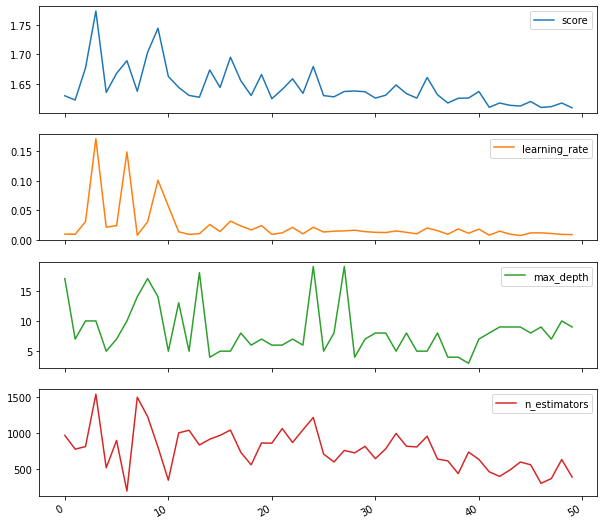

In [ ]:
tpe_results_df = pd.DataFrame.from_records(tpe_results, columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
if develop:
    preds = model.predict(X=valid_X)
    print("LGBM dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
preds7 = model7.predict(X_test)

LGBM dev RMSLE: 0.7932305992166185


In [ ]:
ss = df[['Item_Rating']].head(10)
ss.columns = ['rating']
ss.head()

,rating
0,4.3
1,3.1
2,3.5
3,4.0
4,4.3


In [ ]:
ss['rating_shif1'] = ss['rating'].shift(1)
ss.head()

,rating,rating_shif1
0,4.3,NaN
1,3.1,4.3
2,3.5,3.1
3,4.0,3.5
4,4.3,4.0


In [ ]:
preds = preds7

In [ ]:
preds.shape

(1051,)

In [ ]:
submission['Selling_Price'] = np.expm1(preds)

In [ ]:
submission.columns

Index(['Product', 'Selling_Price'], dtype='object')

In [ ]:
#submission.drop(['Product'], axis=1, inplace=True)
#submission.columns

In [ ]:
submission.to_excel('nags_model7.xls', index=False)
files.download('nags_model7.xls')

In [ ]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(train_X, train_y)
print('[{}] Train LGBM completed'.format(time.time() - start_time))
if develop:
    preds = model.predict(X=valid_X)
    print("LGBM dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))
predsF = model.predict(X_test)
print('[{}] Predict LGBM completed'.format(time.time() - start_time))

In [ ]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5] 
cv_rmsle_array=[] 
for i in alpha:
  model = Ridge(solver="sag", random_state=42, alpha=i)
  model.fit(train_X, train_y)
  preds_cv = model.predict(valid_X)
  rm = rmsle(np.expm1(valid_y), np.expm1(preds_cv))
  cv_rmsle_array.append(rm)

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [ ]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(train_X, train_y)
ridge_preds_tr = model.predict(train_X)
ridge_preds_cv = model.predict(valid_X)

print('Training error', rmsle(np.expm1(train_y), np.expm1(ridge_preds_tr)))
ridge_rmsle = rmsle(np.expm1(valid_y), np.expm1(ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)

In [ ]:
model3 = FTRL(alpha=0.01, beta=0.1, L1=0.00001, L2=1.0, D=sparse_merge.shape[1], iters=50, inv_link="identity", threads=1)
model3.fit(train_X, train_y)
print('[{}] Train FTRL completed'.format(time.time() - start_time))
if develop:
    preds = model3.predict(X=valid_X)
    print("FTRL dev RMSLE:", rmsle(np.expm1(valid_y), np.expm1(preds)))

preds3 = model.predict(X_test)
print('[{}] Predict FTRL completed'.format(time.time() - start_time))

In [ ]:
train = df.copy()
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [ ]:
#Distribution chart
ax = sns.distplot(df.Item_Rating, kde=False)
plt.show()

In [ ]:
plt.scatter(df['Item_Rating'] , df['price'])

In [ ]:
df.corr()

In [ ]:
df1 = df[['Item_Rating','price']]
a = sns.heatmap(df1)

In [ ]:
ax = sns.heatmap(df, annot=True, fmt="d")

In [ ]:
#a = sns.heatmap(df)
sns.heatmap(df1.corr())

In [ ]:
df.dtypes